In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import det, inv
from scipy.special import gamma
from math import pi, ceil
from scipy.special import erfinv
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from random import randint
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt

warnings.filterwarnings("ignore")

In [172]:
def preprocessing(data, method):
    ts_train = []
    ts_valid = []
    ts_test = []
    ts_param = []
    flag_n = False
    flag_diff = False
    flag_dec = False
    if method is 'normalization':
        flag_n = True
    elif method is 'differencing':
        flag_diff = True
            
    for i in range(data.shape[1]):

        temp = list(data.iloc[6:][i].dropna())
        # print(temp)
        if len(temp) > 130:
            
            cut_off_1 = ceil(len(temp)*0.7)
            cut_off_2 = ceil(len(temp)*0.9)

            temp_train = temp[:cut_off_1]
            temp_val = temp[cut_off_1:cut_off_2]
            temp_test = temp[cut_off_2:]

            if flag_n is True:
                ts_param.append([np.mean(temp_train), np.std(temp_train), np.mean(temp_val), 
                np.std(temp_val), np.mean(temp_test), np.std(temp_test)])
                
                temp_train = (temp_train - np.mean(temp_train)) / np.std(temp_train)
                ts_train.append(temp_train)
                

                temp_val = (temp_val - np.mean(temp_val)) / np.std(temp_val)
                ts_valid.append(temp_val)

                temp_test = (temp_test - np.mean(temp_test)) / np.std(temp_test)
                ts_test.append(temp_test)
                

            elif flag_diff is True:

                temp_train = pd.Series(temp_train)
                temp_train_log_diff = temp_train - temp_train.shift()
                temp_train_log_diff[0] = temp_train[0]
                temp_train_log_diff.dropna(inplace=True)
                ts_train.append(temp_train_log_diff.values)

                temp_val = pd.Series(temp_val)
                temp_val_log_diff = temp_val - temp_val.shift()
                temp_val_log_diff[0] = temp_val[0]
                temp_val_log_diff.dropna(inplace=True)
                ts_valid.append(temp_val_log_diff.values)

                temp_test = pd.Series(temp_test)
                temp_test_log_diff = temp_test - temp_test.shift()
                temp_test_log_diff[0] = temp_test[0]
                temp_test_log_diff.dropna(inplace=True)
                ts_test.append(temp_test_log_diff.values)
                
    return ts_train, ts_valid, ts_test, ts_param

# ts_train, ts_valid, ts_test, ts_param = preprocessing(df_temp, method='normalization')

In [166]:
def generate_synthetic_data_df_multivar(n_samples=200, n_exog_vars=4):
    """
    Generates a synthetic dataset with a clear relationship between the target and multiple exogenous variables.
    Returns the data as pandas DataFrames.
    """
    exog_data = {}
    
    for i in range(n_exog_vars):
        # Exogenous variable
        exog_data[i] = np.linspace(0, 10*(i+1), n_samples) + np.random.normal(0, 1, n_samples)
    
    # Create a DataFrame for exogenous variables
    exog_df = pd.DataFrame(exog_data)
    
    # Target variable influenced by the sum of exogenous variables with some noise
    target = exog_df.sum(axis=1) + 5 * np.sin(exog_df[0]) + np.random.normal(0, 2, n_samples)
    target_df = pd.DataFrame(target, columns=[0])
    
    return target_df, exog_df

synthetic_target, synthetic_exog = generate_synthetic_data_df_multivar()

In [205]:
import numpy as np
from numpy.linalg import det, inv
from scipy.special import gamma
from math import pi
from scipy.special import erfinv

class AutoregressiveTree:
    
    def __init__(self, p, u0=0, alpha_u=1):
        
        erf_temp = np.zeros([7,1])
        for i in range(1,8):
            erf_temp[i-1] = erfinv((i/4) - 1)
        
        self._erf = erf_temp
        self._p = p
        self._alpha_W = p + 2
        self._u0 = u0
        self._alpha_u = alpha_u
    
    def sample_mean(self, data):
        return sum(data) / len(data)
    
    def scatter_matrix(self, data, uN_):
        temp = data - uN_
        SN = 0
        for row in temp:
            row = row[:, np.newaxis]
            SN += row * row.T
        
        return SN
    
    def WN_func(self, uN_, SN, W0, N):
        temp = self._u0 - uN_
        temp = temp[:, np.newaxis]
        WN = W0 + SN + ((self._alpha_u * N) / (self._alpha_u + N)) * np.dot(temp, temp.T)
        return WN
    
    def WN_d_func(self, u0_, uN_d_, SN_d_, W0_, N_):
        temp = u0_ - uN_d_
        temp = temp[:, np.newaxis]
        WN_ = W0_ + SN_d_ + ((self._alpha_u * N_) / (self._alpha_u + N_)) * np.dot(temp, temp.T)
        return WN_
    
    def MAP_param(self, N, uN_, WN):
        ut = ((self._alpha_u * self._u0) + (N * uN_)) / (self._alpha_u + N)
        Wt_inv = (1 / (self._alpha_W + N - (self._p + 1))) * WN
        return ut, Wt_inv
    
    def param(self, data):
        N = len(data)
        uN_ = self.sample_mean(data)
        SN = self.scatter_matrix(data, uN_)
        W0 = np.identity(SN.shape[0])
        WN = self.WN_func(uN_, SN, W0, N)
        ut, Wt_inv = self.MAP_param(N, uN_, WN)
        W = inv(Wt_inv)
        var = 1 / W[-1, -1]
        Wpp = inv(Wt_inv[:-1, :-1])
        b = np.zeros([self._p, 1])
        for j in range(len(b)):
            for i in range(self._p):
                b[j] += Wt_inv[-1, i] * Wpp[i, j]
        
        m = ut[-1]
        for i in range(self._p):
            m += b[i] * ut[i]
        
        return var, b, m[0]
    
    def c_func(self, l, alpha):
        c = 1
        #   for loop goes from 1 to l
        for i in range(1, l + 1):
            c *= gamma((alpha + 1 - i) / 2)
        
        return c
    
    def pds_func(self, N, W0, WN):
        pds = (pi**(-((self._p + 1) * N) / 2)) + \
        ((self._alpha_u / (self._alpha_u + N))**((self._p + 1) / 2)) + \
        (self.c_func(self._p + 1, self._alpha_W + N) / self.c_func(self._p + 1, self._alpha_W)) * (det(W0)**(self._alpha_W / 2))*(det(WN)**(-(self._alpha_W + N) / 2))
        return pds
    
    def pd_s_func(self, u0_, N_, W0_, WN_):
        pds = (pi**(-((self._p + 1) * N_) / 2)) + \
        ((self._alpha_u / (self._alpha_u + N_))**((self._p + 1) / 2)) + \
        (self.c_func(self._p + 1, self._alpha_W - 1 + N_) / self.c_func(self._p + 1, self._alpha_W - 1)) * (det(W0_)**((self._alpha_W - 1) / 2))*(det(WN_)**(-(self._alpha_W - 1 + N_) / 2))
        return pds
    
    def mult_func(self, l, alpha, N):
        c = 1
        #   for loop goes from 1 to l
        for i in range(1, l + 1):
            c *= ((alpha + 1 + N - i)/(alpha + 1 - i))
        
        return c

    def pds_func2(self, N, W0, WN, u0_, N_, W0_, WN_):

        pds = (det(W0)**(self._alpha_W / 2))*det(WN)**(-(self._alpha_W + N) / 2) / (det(W0_)**((self._alpha_W - 1) / 2))*(det(WN_)**(-(self._alpha_W - 1 + N_) / 2)) * \
        self.mult_func(self._p + 1,self._alpha_W, N)                                                                                                             

        return pds

    def LeafScore(self, data):
        N = len(data)
        uN_ = self.sample_mean(data)
        SN = self.scatter_matrix(data, uN_)
        W0 = np.identity(SN.shape[0])
        WN = self.WN_func(uN_, SN, W0, N)
        ut, Wt_inv = self.MAP_param(N, uN_, WN)
        pds = self.pds_func(N, W0, WN)
        data_ = []
        for x in data:
            data_.append(x[:-1])
        
        N_ = len(data_)
        uN_d_ = self.sample_mean(data_)
        SN_d_ = self.scatter_matrix(data_, uN_d_)
        u0_ = ut[:-1]
        W0_ = inv(inv(W0)[:-1, :-1])
        WN_d_ = self.WN_d_func(u0_, uN_d_, SN_d_, W0_, N_)
        pds_ = self.pd_s_func(u0_, N_, W0_, WN_d_)
        if N > 20:
            pds2 = self.pds_func2(N, W0, WN, u0_, N_, W0_, WN_d_)
        else:
            pds2 =  pds/pds_
        # print("frac: ", pds/pds_)
        # print("frac2: " , pds2)
        return pds2
    
    def test_split(self, index, value, dataset):
        left, right = list(), list()
        for row in dataset:
            if row[index] < value:
                left.append(row)
            else:
                right.append(row)
        return left, right
    
    def get_split(self, dataset):
        b_index, b_value, b_groups = 999, 999, None
        b_score = self.LeafScore(dataset)
        avg = np.mean(dataset, axis=0)[:-1]
        sigma = np.std(dataset, axis=0)[:-1]
        for index in range(len(avg)):
            for i in range(len(self._erf)):
                value = avg[index] + sigma[index] * self._erf[i]
                groups = self.test_split(index, value, dataset)
                new_score = 1
                for group in groups:
                    if len(group) != 0:
                        new_score *= self.LeafScore(group)
            
                        if new_score > b_score:
                            b_index, b_value, b_score, b_groups = index, value, new_score, groups
        
        return {'index':b_index, 'value':b_value, 'groups':b_groups}
    
    def to_terminal(self, group):
        outcomes = self.param(group)
        return outcomes
    
    def split(self, node, max_depth, min_size, depth):
        left, right = node['groups']
        del(node['groups'])
        if not left or not right:
            node['left'] = node['right'] = self.to_terminal(left + right)
            return
        
        if depth >= max_depth:
            node['left'], node['right'] = self.to_terminal(left), self.to_terminal(right)
            return
        
        if len(left) <= min_size:
            node['left'] = self.to_terminal(left)
        else:
            node['left'] = self.get_split(left)
            if node['left']['groups'] is None:
                node['left'] = self.to_terminal(left)
            else:
                self.split(node['left'], max_depth, min_size, depth+1)
        
        if len(right) <= min_size:
            node['right'] = self.to_terminal(right)
        else:
            node['right'] = self.get_split(right)
            if node['right']['groups'] is None:
                node['right'] = self.to_terminal(right)
            else:
                self.split(node['right'], max_depth, min_size, depth+1)
    
    def build_tree(self, train, max_depth, min_size):
        root = self.get_split(train)
        if root['groups'] is None:
            root['root'] = self.to_terminal(train)
            root['index'] = None
            root['value'] = None
            del(root['groups'])
        else:
            self.split(root, max_depth, min_size, 1)
        
        return root
    
    def print_tree(self, node, depth=0):
        if isinstance(node, dict):
            if node['value'] is None:
                print(node)
                return
            print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
            self.print_tree(node['left'], depth+1)
            self.print_tree(node['right'], depth+1)
    
        else:
            print('%s[%s]' % ((depth*' ', node)))
    
    def predict(self, node, row):
        if 'root' in node:
            return node['root']
        if row[node['index']] < node['value']:
            if isinstance(node['left'], dict):
                return self.predict(node['left'], row)
            else:
                return node['left']
        else:
            if isinstance(node['right'], dict):
                return self.predict(node['right'], row)
            else:
                return node['right']

In [ ]:
p = 3
df_temp2 = pd.concat([synthetic_target,synthetic_exog], axis=1)
# print(df_temp2.shape)

# ts_train, ts_valid, ts_test, ts_param = preprocessing(df_temp[0], method='normalization')
train = []
for s in ts_train:
    temp = []
    for i in range(len(s) - (p + 1)):
        temp.append(s[i:i + p + 1])
    train.append(temp)

d = train[0][0:200]
d_exog = train[1:][0:100]
# print(len(d), len(d[0]))
ART = AutoregressiveTree(p)
tree = ART.build_tree(d,100,3)

ART.print_tree(tree)

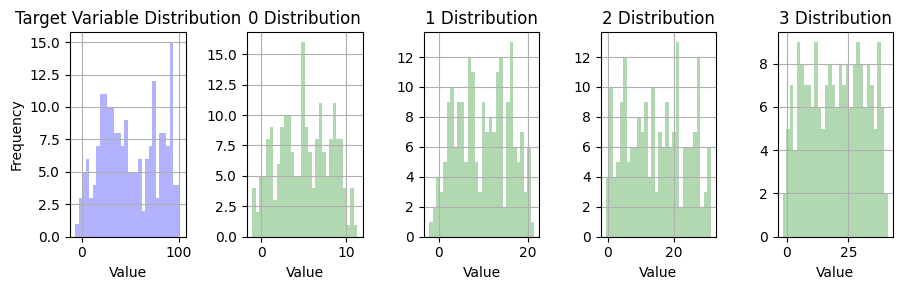

In [224]:
def plot_data_distributions_grid(target_df, exog_df):
    """
    Plots the distributions of the target and multiple exogenous variables in a grid layout.
    """
    n_exog_vars = exog_df.shape[1]
    
    fig, axes = plt.subplots(nrows=1, ncols=n_exog_vars+1, figsize=(9, 3))

    # Plotting target variable distribution
    target_df[0].hist(ax=axes[0], bins=30, color='blue', alpha=0.3)
    axes[0].set_title("Target Variable Distribution")
    axes[0].set_xlabel("Value")
    axes[0].set_ylabel("Frequency")

    # Plotting exogenous variable distributions
    for i, col in enumerate(exog_df.columns):
        exog_df[col].hist(ax=axes[i+1], bins=30, color='green', alpha=0.3)
        axes[i+1].set_title(f"{col} Distribution")
        axes[i+1].set_xlabel("Value")

    plt.tight_layout()
    plt.show()

plot_data_distributions_grid(synthetic_target, synthetic_exog)

merged_pd = pd.concat([synthetic_target,synthetic_exog],axis=1)

In [201]:
def time_series_pred(data, time_series_index, pred_method, max_p, preprocessing_method):
    ts_train, ts_valid, ts_test, ts_param = preprocessing(data, method=preprocessing_method)

    p_set = [i for i in range(1,max_p+1)]
    mse_our_model = []
    mse_arima = []
    valid_prediction_list = []
    valid_prediction_list_cumsum = []
    #   Example
    idx = time_series_index
    d_val = ts_valid[idx][1:]
    d_test = ts_test[idx]
    tree_list = []
    for p in p_set:
        train = []
        for s in ts_train:
            temp = []
            for i in range(len(s) - (p + 1)):
                temp.append(s[i:i + p + 1])

            train.append(temp)
        d = train[idx]
        # print(len(d),len(d[0]))

        ART = AutoregressiveTree(p)
        tree = ART.build_tree(d, 100, 3)
        tree_list.append(tree)
        valid_prediction = []
        valid_window = d[-1][1:]
        moving_val = ts_train[idx]
        if pred_method is 'ART':
            for i in range(len(d_val)):
                parameters = ART.predict(tree, valid_window)
                prediction_temp = np.dot(valid_window[:,np.newaxis].T,parameters[1]) + parameters[2]
                valid_prediction.append(prediction_temp[0][0])
                valid_window = np.append(valid_window, d_val[i])
                valid_window = valid_window[1:]
            valid_prediction_list.append(valid_prediction)
            valid_prediction = pd.Series(valid_prediction, copy=True)
            if preprocessing_method is 'differencing':
                train_s = pd.Series(ts_train[idx], copy=True).cumsum()
                last_value_train= pd.Series.tolist(train_s)[-1]
                valid_prediction_temp = [0]*(len(valid_prediction)+1)
                valid_prediction_temp[1:] = valid_prediction
                valid_prediction_temp[0] = last_value_train
                valid_prediction_temp = pd.Series(valid_prediction_temp, copy=True)
                valid_prediction_cumsum = valid_prediction_temp.cumsum()
                valid_prediction_list_cumsum.append(valid_prediction_cumsum)
            elif preprocessing_method is 'normalization':
                d_val_mean = ts_param[idx][2]
                d_val_std = ts_param[idx][3]
                valid_prediction_denorm= (valid_prediction * d_val_std) + d_val_mean
                valid_prediction_list_cumsum.append(valid_prediction_denorm)
        elif pred_method is 'AR':
            for i in range(len(d_val)):
                #           alid_window = np.append(valid_window, prediction)
                moving_val = moving_val[~np.isnan(moving_val)]
                model = ARIMA(moving_val, order=(p,1,0))
                model_fit = model.fit()
                prediction_temp = model_fit.forecast()
                valid_prediction.append(prediction_temp[0])
                moving_val = np.append(moving_val, d_val[i])
                d_val = pd.Series(d_val, copy=True)
            valid_prediction = pd.Series(valid_prediction, copy=True)
            valid_prediction_list.append(valid_prediction)
            if preprocessing_method is 'differencing':
                train_s = pd.Series(ts_train[idx], copy=True).cumsum()
                last_value_train= pd.Series.tolist(train_s)[-1]
                valid_prediction_temp = [0]*(len(valid_prediction)+1)
                valid_prediction_temp[1:] = valid_prediction
                valid_prediction_temp[0] = last_value_train
                valid_prediction_temp = pd.Series(valid_prediction_temp, copy=True)
                valid_prediction_cumsum = valid_prediction_temp.cumsum()
                valid_prediction_list_cumsum.append(valid_prediction_cumsum)
            elif preprocessing_method is 'normalization':
                d_val_mean = ts_param[idx][2]
                d_val_std = ts_param[idx][3]
                valid_prediction_denorm= (valid_prediction * d_val_std) + d_val_mean
                valid_prediction_list_cumsum.append(valid_prediction_denorm)

    if preprocessing_method is 'differencing':
        d_val_cumsum = ts_valid[idx].cumsum()
    elif preprocessing_method is 'normalization':
        d_val_mean = ts_param[idx][2]
        d_val_std = ts_param[idx][3]
        d_val_cumsum = (d_val * d_val_std) + d_val_mean
    else:
        d_val_cumsum = d_val
        
        
    return d_val, d_val_cumsum, valid_prediction_list, valid_prediction_list_cumsum, tree_list


In [202]:
def hit_rate(ts_true, ts_pred):
    diff_true = np.diff(ts_true)
    diff_pred = np.diff(ts_pred)
    return np.sum(np.sign(diff_true) == np.sign(diff_pred)) / len(diff_true)

In [220]:
merged_pd.columns = [0,1,2,3,4]

In [222]:
max_p= 8
hit_rate_ART_all_samples = []
hit_rate_AR_all_samples = []
rmse_ART_all_samples = []
rmse_AR_all_samples = []
time_series_index_list = [0,1,2,3,4] #, 786, 396, 276, 614, 377, 101, 124, 62, 35]
for i in range(0,4):
    time_series_index = time_series_index_list[i]
    print('Processing... time series number: ',time_series_index)
    time_series_index_list.append(time_series_index)
    Ground_truth_diff, Ground_truth, valid_prediction_diff_ART_list, valid_prediction_ART_list, tree = time_series_pred(data=merged_pd, 
                                    time_series_index=time_series_index, pred_method='ART', max_p=max_p, preprocessing_method='normalization')
    # _, _, valid_prediction_diff_AR_list, valid_prediction_AR_list, _ = time_series_pred(data=df3, 
    #                                 time_series_index=time_series_index, pred_method='AR', max_p=max_p, preprocessing_method='normalization')

    hit_rate_ART_list = []
    hit_rate_AR_list = []
    rmse_ART_list = []
    rmse_AR_list = []
    for i in range(max_p):
        hit_rate_ART_list.append(hit_rate(Ground_truth, valid_prediction_ART_list[i]))
        # hit_rate_AR_list.append(hit_rate(Ground_truth, valid_prediction_AR_list[i]))
        rmse_ART_list.append(sqrt(mean_squared_error(Ground_truth, valid_prediction_ART_list[i])))
        # rmse_AR_list.append(sqrt(mean_squared_error(Ground_truth, valid_prediction_AR_list[i])))
    hit_rate_ART_all_samples.append(hit_rate_ART_list)
    # hit_rate_AR_all_samples.append(hit_rate_AR_list)
    rmse_ART_all_samples.append(rmse_ART_list)
    # rmse_AR_all_samples.append(rmse_AR_list)

Processing... time series number:  0
Processing... time series number:  1
Processing... time series number:  2
Processing... time series number:  3


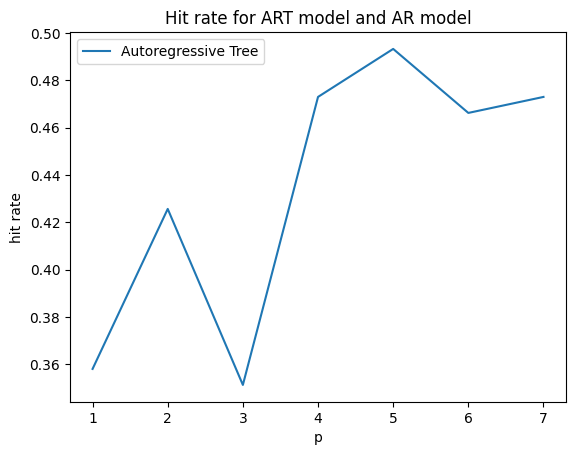

In [223]:
hit_rate_ART_list = np.mean(np.asarray(hit_rate_ART_all_samples), axis=0)
# hit_rate_AR_list = np.mean(np.asarray(hit_rate_AR_all_samples), axis=0)

plt.plot(range(1, max_p), hit_rate_ART_list[:-1], label='Autoregressive Tree')
# plt.plot(range(1, max_p), hit_rate_AR_list[:-1], label='AR model')
plt.title('Hit rate for ART model and AR model')
plt.xlabel('p')
plt.ylabel('hit rate')
plt.legend()
plt.show()